In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
import re
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
import math
import plotly.graph_objects as go
import pandas as pd

import argparse
import queue
import imutils
from sktime.datatypes._panel._convert import from_2d_array_to_nested





In [4]:
video_path= 'input.mp4'

# 1. Calibrate camera with current video

In [5]:
# get first frame of video
cap = cv2.VideoCapture(video_path)
ret, frame = cap.read()

In [6]:
# Mouse callback function to collect points
points=[]
cv2.imshow('Select Points', frame)
def get_points(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        points.append((x, y))
        print("Point selected: ({}, {})".format(x, y))

# Set the mouse callback
cv2.setMouseCallback('Select Points', get_points)

# Wait for the user to select points
cv2.waitKey(0)

# Close the image window
cv2.destroyAllWindows()

# Print the selected points
print("Selected Points:", points)

Point selected: (666, 209)
Point selected: (1243, 205)
Point selected: (1574, 835)
Point selected: (354, 846)
Point selected: (495, 338)
Point selected: (1422, 332)
Selected Points: [(666, 209), (1243, 205), (1574, 835), (354, 846), (495, 338), (1422, 332)]


In [7]:
points=[(666, 209), (1243, 205), (1574, 835), (354, 846), (495, 338), (1422, 332)]
#plot points on frame
for point in points:
    cv2.circle(frame, point, 5, (0, 0, 255), -1)
cv2.imshow('points',frame)
cv2.waitKey(0)

# Close the image window
cv2.destroyAllWindows()

In [8]:
#true coords
# top left corner, top right corner, bottom right corner, bottom left corner, pole left, pole right
true_coords = [(0,23.77, 0), (10.97,23.77,  0), (10.97,0, 0),(0,0,0), (0.0, 5.485,1.07), (12.32,5.485,1.07)]

In [10]:
A = []
for i in range(6):
    X, Y, Z = true_coords[i]
    u, v = points[i]
    A.append([X, Y, Z, 1, 0, 0, 0, 0, -u*X, -u*Y, -u*Z, -u])
    A.append([0, 0, 0, 0, X, Y, Z, 1, -v*X, -v*Y, -v*Z, -v])
A = np.array(A)
U, S, V = np.linalg.svd(A)

# get last column of V
p = V[-1, :]

# reshape to 
M3D = np.reshape(p, (3, 4))

a1 = M3D[0, :3]
a2 = M3D[1, :3]
a3 = M3D[2, :3]
b1 = M3D[0, 3]
b2 = M3D[1, 3]
b3 = M3D[2, 3]

rho = 1 / np.linalg.norm(a3)
cx = rho**2 * np.dot(a1, a3)
cy = rho**2 * np.dot(a2, a3)
cos_theta = -np.dot(np.cross(a1, a3), np.cross(a2, a3)) / (np.linalg.norm(np.cross(a1, a3)) * np.linalg.norm(np.cross(a2, a3)))
sin_tetha = np.sqrt(1 - cos_theta**2)
alpha = rho**2 * np.linalg.norm(np.cross(a1, a3)) * sin_tetha
beta = rho**2 * np.linalg.norm(np.cross(a2, a3)) * sin_tetha

K = np.array([[alpha, -alpha* (cos_theta/sin_tetha), cx], [0, beta/ sin_tetha, cy], [0, 0, 1]])


# get R and T
r1 = (np.cross(a2, a3) / np.linalg.norm(np.cross(a2, a3)))
r3= rho * a3
r2 = np.cross(r3, r1)

b = np.array([b1, b2, b3])
t = rho* np.linalg.inv(K).dot(b)

In [11]:
R = np.array([r1, r2, r3])
t = t.reshape(3, 1)


# Calibrazione Caglioti

In [49]:


def rescale_points_np(points, original_size, new_size):
    """
    Rescales points from the original resolution to the new resolution using NumPy.
    
    :param points: NumPy array of shape (n, 2) representing points (x, y).
    :param original_size: Tuple representing the original resolution (width, height).
    :param new_size: Tuple representing the new resolution (width, height).
    :return: NumPy array of shape (n, 2) representing the rescaled points.
    """
    original_width, original_height = original_size
    new_width, new_height = new_size
    
    scale_x = new_width / original_width
    scale_y = new_height / original_height
    
    # Create a scaling array
    scaling_factors = np.array([scale_x, scale_y])
    
    # Rescale points
    rescaled_points = points * scaling_factors
    return rescaled_points

In [51]:
# Image points (u, v) and corresponding ground plane points (x, y)
# (666, 209), (1243, 205), (1574, 835), (354, 846)
original_resolution = (1920, 1080)
new_resolution = (1280, 720)
image_points = np.array([
    [670, 835], [1250, 835], [1580, 205], [360, 205]
])
rescaled_points = rescale_points_np(image_points, original_resolution, new_resolution)

ground_points = np.array([
    [91,2377], [1188,2377], [1188,0],[91,0]
])

# Compute the homography H
H, _ = cv2.findHomography(ground_points, rescaled_points)

# Real-world coordinates of the tops of the net posts
E_top = np.array([0,  1188, 107])
F_top = np.array([1279,1188, 107])

# Transform to ground plane using H
E_ground = H @ E_top
E_ground /= E_ground[2]
F_ground = H @ F_top
F_ground /= F_ground[2]

# Find the camera center by intersecting the lines (E, E') and (F, F')
# Represent the lines in homogeneous coordinates
line_E = np.cross(E_top, E_ground)
line_F = np.cross(F_top, F_ground)

# Camera center O is the intersection of these lines
O = np.cross(line_E, line_F)
O /= O[2]

# Compute intrinsic and extrinsic parameters
# Normalize the homography matrix
H_normalized = H / np.linalg.norm(H[:, 0])



In [52]:
# scatter image points
fig = go.Figure()
fig.add_trace(go.Scatter(x=rescaled_points[:, 0], y=rescaled_points[:, 1], mode='markers', name='Image Points'))

In [53]:
image_points= np.float32(rescaled_points)
ground_points= np.float32(ground_points)
M = cv2.getPerspectiveTransform(image_points,ground_points)
M

array([[ 1.15210595e+00, -6.63997477e-01, -1.08027831e+02],
       [-1.61895807e-16,  2.29827689e+00, -3.14097854e+02],
       [ 3.12092596e-19, -1.06690382e-03,  1.00000000e+00]])

In [54]:
H

array([[7.41416020e-01, 2.94295448e-01, 1.72531142e+02],
       [8.28104685e-17, 4.35108540e-01, 1.36666672e+02],
       [2.38876343e-19, 4.64218947e-04, 1.00000000e+00]])

In [55]:
transformed_points = np.dot(M, np.stack([image_points[:, 0], image_points[:, 1], np.ones(image_points.shape[0])]))

In [56]:
transformed_points /= transformed_points[2]

In [57]:
transformed_points

array([[9.10000014e+01, 1.18800006e+03, 1.18800001e+03, 9.10000002e+01],
       [2.37699991e+03, 2.37699991e+03, 0.00000000e+00, 1.33093180e-13],
       [1.00000000e+00, 1.00000000e+00, 1.00000000e+00, 1.00000000e+00]])

In [58]:
fig.add_trace(go.Scatter(x=transformed_points[0], y=transformed_points[1], mode='markers', name='Transformed Points'))

In [59]:
# apply M to E and F
E_image = np.float32([495, 1080-335]) 
F_image= np.float32([1420, 1080-335])
E_image = rescale_points_np(E_image, original_resolution, new_resolution)
F_image = rescale_points_np(F_image, original_resolution, new_resolution)
E_transformed = np.dot(M, np.array([E_image[0], E_image[1], 1]))
E_transformed /= E_transformed[2]

F_transformed = np.dot(M, np.array([F_image[0], F_image[1], 1]))
F_transformed /= F_transformed[2]

In [60]:
fig.add_trace(go.Scatter(x=[E_image[0], F_image[0]], y=[E_image[1], F_image[1],], mode='markers', name='E, F'))
fig.add_trace(go.Scatter(x=[E_transformed[0], F_transformed[0]], y=[E_transformed[1], F_transformed[1]], mode='markers', name='Transformed E, F'))
#fig.add_trace(go.Scatter(x=[E_ground[0], F_ground[0]], y=[E_ground[1], F_ground[1]], mode='markers', name='Ground E, F'))

In [61]:
E_top = np.array([0,  1188, 107])
F_top = np.array([1279,1188, 107])

In [62]:
fig.add_trace(go.Scatter(x=[E_top[0], F_top[0]], y=[E_top[1], F_top[1]], mode='markers', name='Ground E, F'))

In [122]:
import plotly.offline as pyo

E_g = E_transformed
F_g = F_transformed
E_g[2]= 0
F_g[2]= 0
# line_E = np.cross(E_top, E_transformed)
# line_F = np.cross(F_top, F_transformed)

# line_E /= line_E[2]
# line_F /= line_F[2]
# line_E, line_F
def plot_two_lines_3d_plotly(p1, p2, p3, p4):
    # Extracting coordinates for line 1
    x1, y1, z1 = p1
    x2, y2, z2 = p2
    
    # Direction vector for line 1
    d1 = np.array([x2 - x1, y2 - y1, z2 - z1])
    
    # Parametric values for line 1
    t1 = np.linspace(-1, 2, 100)
    
    # Line 1 points
    x_line1 = x1 + t1 * d1[0]
    y_line1 = y1 + t1 * d1[1]
    z_line1 = z1 + t1 * d1[2]
    
    # Extracting coordinates for line 2
    x3, y3, z3 = p3
    x4, y4, z4 = p4
    
    # Direction vector for line 2
    d2 = np.array([x4 - x3, y4 - y3, z4 - z3])
    
    # Parametric values for line 2
    t2 = np.linspace(-1, 2, 100)
    
    # Line 2 points
    x_line2 = x3 + t2 * d2[0]
    y_line2 = y3 + t2 * d2[1]
    z_line2 = z3 + t2 * d2[2]
    
    # Create trace for line 1
    line_trace1 = go.Scatter3d(
        x=x_line1,
        y=y_line1,
        z=z_line1,
        mode='lines',
        name='Line 1',
        line=dict(color='blue', width=2)
    )
    
    # Create trace for line 2
    line_trace2 = go.Scatter3d(
        x=x_line2,
        y=y_line2,
        z=z_line2,
        mode='lines',
        name='Line 2',
        line=dict(color='red', width=2)
    )
    
    # Create trace for points
    points_trace = go.Scatter3d(
        x=[x1, x2, x3, x4],
        y=[y1, y2, y3, y4],
        z=[z1, z2, z3, z4],
        mode='markers',
        name='Points',
        marker=dict(color='black', size=5)
    )
    
    # Layout
    layout = go.Layout(
        title='Two Lines through Four Points in 3D',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        )
    )
    
    # Create the figure
    fig = go.Figure(data=[line_trace1, line_trace2, points_trace], layout=layout)
    
    # Plot the figure
    pyo.iplot(fig)
    
def find_intersection_point(p1, p2, p3, p4):
    # Extracting coordinates for line 1
    x1, y1, z1 = p1
    x2, y2, z2 = p2
    
    # Direction vector for line 1
    d1 = np.array([x2 - x1, y2 - y1, z2 - z1])
    
    # Parametric values for line 1
    t1 = np.linspace(-1, 2, 100)
    
    # Line 1 points
    x_line1 = x1 + t1 * d1[0]
    y_line1 = y1 + t1 * d1[1]
    z_line1 = z1 + t1 * d1[2]
    
    # Extracting coordinates for line 2
    x3, y3, z3 = p3
    x4, y4, z4 = p4
    
    # Direction vector for line 2
    d2 = np.array([x4 - x3, y4 - y3, z4 - z3])
    
    # Parametric values for line 2
    t2 = np.linspace(-1, 2, 100)
    
    # Line 2 points
    x_line2 = x3 + t2 * d2[0]
    y_line2 = y3 + t2 * d2[1]
    z_line2 = z3 + t2 * d2[2]
    
    # Solve for the intersection point
    A = np.array([
        [d1[0], -d2[0]],
        [d1[1], -d2[1]],
        [d1[2], -d2[2]]
    ])
    B = np.array([x3 - x1, y3 - y1, z3 - z1])
    t = np.linalg.lstsq(A, B, rcond=None)[0]
    
    # Calculate intersection point coordinates
    intersection_x = x1 + t[0] * d1[0]
    intersection_y = y1 + t[0] * d1[1]
    intersection_z = z1 + t[0] * d1[2]
    
    return intersection_x, intersection_y, intersection_z

# Function to plot the intersection point of two lines in 3D space using Plotly
def plot_intersection_point_3d_plotly(p1, p2, p3, p4):
    # Find intersection point
    intersection_point = find_intersection_point(p1, p2, p3, p4)
    
    # Create trace for intersection point
    intersection_trace = go.Scatter3d(
        x=[intersection_point[0]],
        y=[intersection_point[1]],
        z=[intersection_point[2]],
        mode='markers',
        name='Intersection Point',
        marker=dict(color='green', size=10)
    )
    
    # Plot two lines and points
    plot_two_lines_3d_plotly(p1, p2, p3, p4)
    
    # Add intersection point to the plot
    fig = pyo.iplot([intersection_trace], filename='intersection_point')
    
    return intersection_point

# Example usage
p1 = E_g
p2 = E_top
p3= F_g
p4= F_top
intersection_point = plot_intersection_point_3d_plotly(p1, p2, p3, p4)
print("Intersection Point:", intersection_point)

Intersection Point: (674.840555006513, -1961.3764882255302, 696.1406771205842)


In [120]:
# find flipped intersection point
# Example usage
p1 = E_g
# find E_g symmetric with respect to the line E_top, F_top in y axis
E_g_simm = np.array([E_g[0], 2*E_top[1]-E_g[1], E_g[2]])
p1 = E_g_simm


p2 = E_top
p3= F_g
F_g_simm = np.array([F_g[0], 2*F_top[1]-F_g[1], F_g[2]])
p3 = F_g_simm
p4= F_top


# plot E_g, E_g_simm, F_g, F_g_simm
fig2 = go.Figure()
fig2.add_trace(go.Scatter(x=[E_g[0], E_g_simm[0]], y=[E_g[1], E_g_simm[1]], mode='markers', name='E_g, E_g_simm'))
fig2.add_trace(go.Scatter(x=[F_g[0], F_g_simm[0]], y=[F_g[1], F_g_simm[1]], mode='markers', name='F_g, F_g_simm'))
# add E_top, F_top
fig2.add_trace(go.Scatter(x=[E_top[0], F_top[0]], y=[E_top[1], F_top[1]], mode='markers', name='E_top, F_top'))
fig2.show()

In [121]:
intersection_point_flipped = plot_intersection_point_3d_plotly(p1, p2, p3, p4)
print("Intersection Point:", intersection_point_flipped)

Intersection Point: (674.840555006513, 4337.37648822553, 696.1406771205842)


In [123]:
# Function to plot the lines, points, and intersection point in 3D using Plotly
def plot_lines_points_intersection_3d_plotly(p1, p2, p3, p4):
    # Extracting coordinates for line 1
    x1, y1, z1 = p1
    x2, y2, z2 = p2
    
    # Direction vector for line 1
    d1 = np.array([x2 - x1, y2 - y1, z2 - z1])
    
    # Parametric values for line 1
    t1 = np.linspace(-1, 2, 500)
    
    # Line 1 points
    x_line1 = x1 + t1 * d1[0]
    y_line1 = y1 + t1 * d1[1]
    z_line1 = z1 + t1 * d1[2]
    
    # Extracting coordinates for line 2
    x3, y3, z3 = p3
    x4, y4, z4 = p4
    
    # Direction vector for line 2
    d2 = np.array([x4 - x3, y4 - y3, z4 - z3])
    
    # Parametric values for line 2
    t2 = np.linspace(-1, 2, 500)
    
    # Line 2 points
    x_line2 = x3 + t2 * d2[0]
    y_line2 = y3 + t2 * d2[1]
    z_line2 = z3 + t2 * d2[2]
    
    # Solve for the intersection point
    A = np.array([
        [d1[0], -d2[0]],
        [d1[1], -d2[1]],
        [d1[2], -d2[2]]
    ])
    B = np.array([x3 - x1, y3 - y1, z3 - z1])
    t = np.linalg.lstsq(A, B, rcond=None)[0]
    
    # Calculate intersection point coordinates
    intersection_x = x1 + t[0] * d1[0]
    intersection_y = y1 + t[0] * d1[1]
    intersection_z = z1 + t[0] * d1[2]
    
    # Create trace for line 1
    line_trace1 = go.Scatter3d(
        x=x_line1,
        y=y_line1,
        z=z_line1,
        mode='lines',
        name='Line 1',
        line=dict(color='blue', width=2)
    )
    
    # Create trace for line 2
    line_trace2 = go.Scatter3d(
        x=x_line2,
        y=y_line2,
        z=z_line2,
        mode='lines',
        name='Line 2',
        line=dict(color='red', width=2)
    )
    
    # Create trace for points
    points_trace = go.Scatter3d(
        x=[x1, x2, x3, x4],
        y=[y1, y2, y3, y4],
        z=[z1, z2, z3, z4],
        mode='markers',
        name='Points',
        marker=dict(color='black', size=5)
    )
    
    # Create trace for intersection point
    intersection_trace = go.Scatter3d(
        x=[intersection_x],
        y=[intersection_y],
        z=[intersection_z],
        mode='markers',
        name='Intersection Point',
        marker=dict(color='green', size=5)
    )
    
    # Layout
    layout = go.Layout(
        title='Lines, Points, and Intersection Point in 3D',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        )
    )
    
    # Create the figure
    fig = go.Figure(data=[line_trace1, line_trace2, points_trace, intersection_trace], layout=layout)
    
    # Plot the figure
    pyo.iplot(fig)

# Example usage
p1 = E_g
p2 = E_top
p3= F_g
p4= F_top
plot_lines_points_intersection_3d_plotly(p1, p2, p3, p4)

In [124]:
# read bounce dataset
df = pd.read_csv('bounces.csv')
# find first bounce
bounce = df[df['bounce'] == 1].iloc[0]
# extract index of first bounce
bounce_index = bounce.name
bounce_index

16

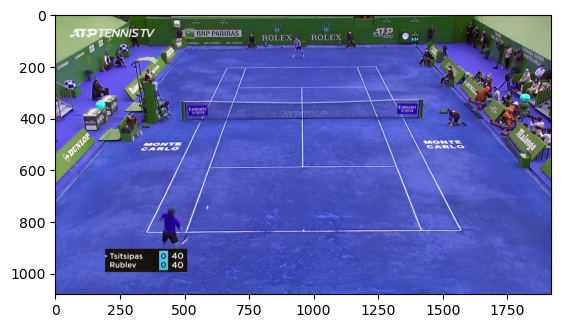

In [125]:
#read bounce_index frame
cap = cv2.VideoCapture(video_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, bounce_index)
ret, frame = cap.read()
plt.imshow(frame)

In [126]:
# extract bounce coordinates
bounce_coords = np.array([bounce['x'],  1080-bounce['y']])
bounce_coords = rescale_points_np(bounce_coords, original_resolution, new_resolution)

In [127]:
bounce_coords

array([391., 219.])

In [128]:
bounce_transformed = np.dot(M, np.array([bounce_coords[0],bounce_coords[1], 1]))
bounce_transformed /= bounce_transformed[2]

In [129]:
fig.add_trace(go.Scatter(x=[bounce_coords[0]], y=[bounce_coords[1]], mode='markers', name='Bounce'))
fig.add_trace(go.Scatter(x=[bounce_transformed[0]], y=[bounce_transformed[1]], mode='markers', name='Transformed Bounce'))

In [130]:
# read player 1 boxes
player1_boxes = pd.read_csv('player1_boxes.csv')
# find player 1 boxes at bounce index
player1_boxes_bounce = player1_boxes.iloc[bounce_index]

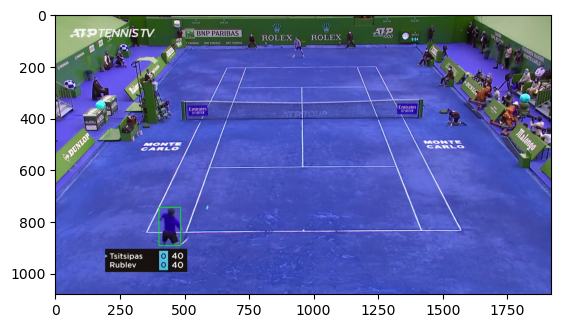

In [75]:
# plot box on frame
box = player1_boxes_bounce[['0', '1', '2', '3']].values
box = box.reshape(-1, 2)
box = box.astype(int)
cv2.rectangle(frame, tuple(box[0]), tuple(box[1]), (0, 255, 0), 2)
plt.imshow(frame)

In [86]:
# find bottolm left and bottolm right box coordinates
top_left = box[0]
bottom_right = box[1]
bottom_left = (top_left[0], bottom_right[1])
# transform in homogeneous coordinates

bottom_right = np.array([bottom_right[0], 1080- bottom_right[1]])
bottom_left = np.array([bottom_left[0], 1080-bottom_left[1]])
bottom_left= rescale_points_np(bottom_left, original_resolution, new_resolution)
bottom_right= rescale_points_np(bottom_right, original_resolution, new_resolution)

bottom_right = np.array([bottom_right[0], bottom_right[1], 1])
bottom_left = np.array([bottom_left[0], bottom_left[1], 1])

In [87]:


ground_player_point_1 = np.dot(M, bottom_left)
ground_player_point_1 /= ground_player_point_1[2]
ground_player_point_2 = np.dot(M, bottom_right)
ground_player_point_2 /= ground_player_point_2[2]

In [88]:
def plane_from_points(p1, p2, p3):
    v1 = p2 - p1
    v2 = p3 - p1
    normal = np.cross(v1, v2)
    normal /= np.linalg.norm(normal)  # Normalize the normal vector
    return normal



def intersect_line_plane(p0, p1, p_co, p_no, epsilon=1e-6):
    """
    Intersects a line defined by two points p0 and p1 with a plane defined by its center point p_co and normal vector p_no.
    
    Parameters:
    - p0, p1: Tuple representing the start and end points of the line.
    - p_co: Tuple representing a point on the plane.
    - p_no: Tuple representing the normal vector of the plane.
    - epsilon: Small value to avoid division by zero errors.
    
    Returns:
    - Intersection point as a tuple or None if no intersection exists.
    """
    u = (p1[0]-p0[0], p1[1]-p0[1], p1[2]-p0[2])
    dot = sum(a*b for a, b in zip(p_no, u))
    
    if abs(dot) > epsilon:
        w = (p0[0]-p_co[0], p0[1]-p_co[1], p0[2]-p_co[2])
        fac = -(sum(a*b for a, b in zip(p_no, w)) / dot)
        u_scaled = (u[0]*fac, u[1]*fac, u[2]*fac)
        return (p0[0]+u_scaled[0], p0[1]+u_scaled[1], p0[2]+u_scaled[2])
    
    return None



def plot_lines_points_bounding_box_3d_plotly(p1, p2, p3, p4):
    x1, y1, z1 = p1
    x2, y2, z2 = p2
    
    # Direction vector for the line
    d = np.array([x2 - x1, y2 - y1, z2 - z1])
    
    # Parametric values for the line
    t = np.linspace(-1, 2, 100)
    
    # Line points
    x_line = x1 + t * d[0]
    y_line = y1 + t * d[1]
    z_line = z1 + t * d[2]
    
    # Points on the Z=0 plane
    x3, y3, z3 = p3
    x4, y4, z4 = p4
    
    # Direction vector of the line p3-p4
    line_direction = np.array([x4 - x3, y4 - y3, z4 - z3])
    
    # Calculate the length of the line segment p3-p4
    line_length = np.linalg.norm(line_direction)
    
    # Normalize the line direction vector
    line_direction_norm = line_direction / line_length
    
    # Calculate the bounding box height
    box_height = 700
    
    # Define points for the bounding box
    
    
    
    p7 = p3 + np.array([0, 0, box_height])
    p8 = p4 + np.array([0, 0, box_height])
    
    normal = plane_from_points(p3, p4, p7)
    intersection_point = intersect_line_plane(p1, p2, p8, normal)
    
    intersection_trace = go.Scatter3d(
        x=[intersection_point[0]],
        y=[intersection_point[1]],
        z=[intersection_point[2]],
        mode='markers',
        name='Intersection Point',
        marker=dict(color='green', size=5)
    )
    print (intersection_point)
    
    # Create the line trace
    line_trace = go.Scatter3d(
        x=x_line,
        y=y_line,
        z=z_line,
        mode='lines',
        name='Line',
        line=dict(color='blue', width=2)
    )
    
    # Create traces for points
    points_trace = go.Scatter3d(
        x=[p3[0], p4[0],  p3[0], p7[0], p8[0], p4[0]],
        y=[p3[1], p4[1],  p3[1], p7[1], p8[1], p4[1]],
        z=[p3[2], p4[2],  p3[2], p7[2], p8[2], p4[2]],
        mode='markers',
        name='Points',
        marker=dict(color='red', size=5)
    )
    
    # Create traces for lines connecting points
    lines_trace = go.Scatter3d(
        x=[p3[0], p4[0],  p3[0], p7[0], p8[0], p4[0], p3[0], p7[0], ],
        y=[p3[1], p4[1],  p3[1], p7[1], p8[1], p4[1], p3[1], p7[1], ],
        z=[p3[2], p4[2],  p3[2], p7[2], p8[2], p4[2], p3[2], p7[2], ],
        mode='lines',
        name='Lines',
        line=dict(color='black', width=2)
    )
    
    # Create the camera and ball traces
    camera_trace = go.Scatter3d(
        x=[x1],
        y=[y1],
        z=[z1],
        mode='markers',
        name='Camera center',
        marker=dict(color='blue', size=5)
    )
    
    ball_trace = go.Scatter3d(
        x=[x2],
        y=[y2],
        z=[z2],
        mode='markers',
        name='Ball',
        marker=dict(color='green', size=5)
    )
    box_trace = go.Mesh3d(
        x=[p3[0], p4[0], p7[0], p8[0], p3[0], p7[0], p8[0], p4[0]],
        y=[p3[1], p4[1], p7[1], p8[1], p3[1], p7[1], p8[1], p4[1]],
        z=[p3[2], p4[2], p7[2], p8[2], p3[2], p7[2], p8[2], p4[2]],
        i=[0, 0, 0, 0, 4, 4, 2, 2],
        j=[1, 2, 3, 4, 5, 6, 7, 6],
        k=[5, 6, 7, 4, 0, 3, 1, 3],
        opacity=0.5,
        color='red'
    )
    
    # Layout
    layout = go.Layout(
        title='Lines, Points, and Bounding Box in 3D',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z'
        )
    )
    
    # Create the figure
    fig = go.Figure(data=[line_trace, points_trace, lines_trace, camera_trace, ball_trace, box_trace, intersection_trace], layout=layout)
    
    # Plot the figure
    pyo.iplot(fig)
bounce_g = bounce_transformed
bounce_g[2]= 0
ground_player_point_1[2]=0
ground_player_point_2[2]=0
plot_lines_points_bounding_box_3d_plotly(intersection_point, bounce_g, ground_player_point_1, ground_player_point_2)

(309.82900051637347, -31.810343719207367, 87.86593682877503)


In [89]:
camera_center=intersection_point

In [149]:
# geta all bounces
bounces = df[df['bounce'] == 1]

# get all y coordintes
y = bounces['y'].values
y = 1080-y
x = bounces['x'].values

# rescale points
bounces_coords = np.array([x, y])
bounces_coords = rescale_points_np(bounces_coords.T, original_resolution, new_resolution)
x = bounces_coords[:, 0]
y = bounces_coords[:, 1]

In [150]:
# function to transform in homogeneous coordinates
def homogeneous(x, y, image_size=720):
    return np.array([x, y, 1])
# function to project on ground plane
def project_on_ground_plane(M, point):
    point = np.dot(M,point)
    point /= point[2]
    return point
def find_box_points(base1, base2, height):
    p1 = base1
    p2 = base2
    p3 = np.array([base1[0], base1[1], height])
    p4 = np.array([base2[0], base2[1], height])
    return p1, p2, p3, p4
def find_plane_points_normal(p1, p2, height):
    box_height = 700
    
    # Define points for the bounding box
    p7 = p1 + np.array([0, 0, box_height])
    p8 = p2 + np.array([0, 0, box_height])
    normal = plane_from_points(p1, p2, p7)
    return p7, p8, normal

In [151]:
player2_boxes = pd.read_csv('player2_boxes.csv')
player2_boxes.shape
# count na
player2_boxes.isna().sum()

0    11
1    11
2    11
3    11
dtype: int64

In [152]:
# fint top left corner of image
top_left = np.array([0,720,1])
# project on the ground
top_left_ground = project_on_ground_plane(M, top_left)
top_left_ground/=top_left_ground[2]
top_left_ground

array([-2.52817977e+03,  5.78296966e+03,  1.00000000e+00])

In [153]:
criteria= 0 # 0 minore 1 maggiore
#understand if the ball is going up or down
if y[0] < y[1]:
    criteria = 1
initial_criteria = criteria
image_y=1080
fig = go.Figure()
# y distance E_top and camera center
y_distance = E_top[1] - camera_center[1]

#center_flipped = np.array([camera_center[0],camera_center[1]+ 2*top_left_ground[1], camera_center[2]]) 
center_flipped= intersection_point_flipped
print(f'center_flipped: {center_flipped}')
print(f'intersection flipped: {intersection_point_flipped}')
#fig.add_trace(go.Scatter3d(x=[camera_center[0], center_flipped[0]], y=[camera_center[1], center_flipped[1]], z=[camera_center[2], center_flipped[2]], mode='markers+lines', name='Camera Center'))
fig.add_trace(go.Scatter3d(x=[E_top[0], F_top[0]], y=[E_top[1], F_top[1]], z=[E_top[2], F_top[2]], mode='markers+lines', name='Original', marker=dict(color='green', size=2)))
indexes= []
intersectios_p1= []
intersections_p2= []
ground_p = []

for i in range(len(y)-1):
    if criteria == 1:
        if y[i+1] > y[i]:
            print("Bounce on player 1 at point: ({}, {})".format(x[i], y[i]))
            #plt.scatter(x[i], y[i], c='r')
            # add i label
            #plt.text(x[i], y[i], str(i+1), color='red', fontsize=12)
            
            #transform bounce in homogeneous coordinates
            
            bounce = homogeneous(x[i], y[i])
            
            # get player box
            player_box = player1_boxes.iloc[i]
            
            box = player_box[['0', '1', '2', '3']].values
            box = box.reshape(-1, 2)
            box = box.astype(int)
            top_left = box[0]
            bottom_right = box[1]
            bottom_left = (top_left[0], bottom_right[1])
            # rescale points
            bottom_right = np.array([bottom_right[0], image_y- bottom_right[1]])
            bottom_left = np.array([bottom_left[0], image_y-bottom_left[1]])
            print(f'Bottom right: {bottom_right}, Bottom left: {bottom_left}')

            bottom_right = rescale_points_np(bottom_right, original_resolution, new_resolution)
            bottom_left = rescale_points_np(bottom_left, original_resolution, new_resolution)
            print(f'Bottom right rescaled: {bottom_right}, Bottom left rescaled: {bottom_left}')

            bottom_right = homogeneous(bottom_right[0], bottom_right[1])
            bottom_left = homogeneous(bottom_left[0], bottom_left[1])
            
            # project on the ground plane
            ground_bounce = project_on_ground_plane(M, bounce)
            ground_bottom_right = project_on_ground_plane(M, bottom_right)
            ground_bottom_left = project_on_ground_plane(M, bottom_left)
            
            # z-coordinate 0
            ground_bounce[2]= 0
            ground_bottom_right[2]= 0
            ground_bottom_left[2]= 0
            
            #get plane points and normal
            p7, p8, normal = find_plane_points_normal(ground_bottom_left, ground_bottom_right, 700)
            intersection_point = intersect_line_plane(camera_center, ground_bounce, p8, normal)
            # add to intersections p1
            intersectios_p1.append(intersection_point)
            
            #int_trace = go.Scatter3d(x=[intersection_point[0]], y=[intersection_point[1]], z=[intersection_point[2]], mode='markers', name='Intersection Point', marker=dict(color='red', size=2))
            #fig.add_trace(int_trace)
            
            # add index to list
            indexes.append(i)
            criteria = 0
        else:
            bounce = homogeneous(x[i], y[i])
            ground_bounce = project_on_ground_plane(M, bounce)
            ground_bounce[2]= 0
            ground_p.append(ground_bounce)
               
            
    if criteria == 0:
        if y[i+1] < y[i]:
            print("Bounce on player 2 at point: ({}, {})".format(x[i], y[i]))
            #plt.scatter(x[i], y[i], c='r')
            #plt.text(x[i], y[i], str(i+1), color='red', fontsize=12)
            indexes.append(i)
            
            player_box = player2_boxes.iloc[i]
            # chack if not na
            if player_box.isna().sum() == 0:
                box = player_box[['0', '1', '2', '3']].values
                box = box.reshape(-1, 2)
                box = box.astype(int)
                top_left = box[0]
                bottom_right = box[1]
                bottom_left = (top_left[0], bottom_right[1])
                bottom_right = np.array([bottom_right[0], image_y- bottom_right[1]])
                bottom_left = np.array([bottom_left[0], image_y-bottom_left[1]])
                print(f'Bottom right: {bottom_right}, Bottom left: {bottom_left}')
                
                # rescale points
                bottom_right = rescale_points_np(bottom_right, original_resolution, new_resolution)
                bottom_left = rescale_points_np(bottom_left, original_resolution, new_resolution)
                print(f'Bottom right rescaled: {bottom_right}, Bottom left rescaled: {bottom_left}')
                
                bottom_right = homogeneous(bottom_right[0], bottom_right[1])
                bottom_left = homogeneous(bottom_left[0], bottom_left[1])
                
                
                bounce = homogeneous(x[i], y[i])
                
                # project on the ground plane
                ground_bottom_right = project_on_ground_plane(M, bottom_right)
                ground_bottom_left = project_on_ground_plane(M, bottom_left)
                ground_bounce = project_on_ground_plane(M, bounce)
            
                
                
                
                # z-coordinate 0
                ground_bottom_right[2]= 0
                ground_bottom_left[2]= 0
                ground_bounce[2]= 0
                
                #get plane points and normal
                p7, p8, normal = find_plane_points_normal(ground_bottom_left, ground_bottom_right, 700)
                if ground_bounce[1] > ground_bottom_left[1]:
                    ground_symm = np.array([ground_bounce[0], 2*p7[1]-ground_bounce[1], ground_bounce[2]])
                    intersection_point = intersect_line_plane(center_flipped, ground_symm, p8, normal)
                    print(f'intersction point: {intersection_point}')
                else:
                    intersection_point = intersect_line_plane(center_flipped, ground_bounce, p8, normal)
                # z_coord = intersection_point[2]
                # transform intersection in array
                # intersection_point = np.array(intersection_point)
                # intersection_point[2] = -z_coord
                # #transform in tuple
                # intersection_point = tuple(intersection_point)
                
                intersections_p2.append(intersection_point)
                #int_trace = go.Scatter3d(x=[intersection_point[0]], y=[intersection_point[1]], z=[intersection_point[2]], mode='markers', name='Intersection Point', marker=dict(color='blue', size=2))
                #fig.add_trace(int_trace)
            
            
            criteria = 1
        else:
            bounce = homogeneous(x[i], y[i])
            ground_bounce = project_on_ground_plane(M, bounce)
            ground_bounce[2]= 0
            ground_p.append(ground_bounce)
  
# scatter intersections p1
intersections_p1 = np.array(intersectios_p1)
fig.add_trace(go.Scatter3d(x=intersections_p1[:, 0], y=intersections_p1[:, 1], z=intersections_p1[:, 2], mode='markers', name='Intersections P1', marker=dict(color='red', size=2)))
#scatter intersections p2
intersections_p2 = np.array(intersections_p2)
fig.add_trace(go.Scatter3d(x=intersections_p2[:, 0], y=intersections_p2[:, 1], z=intersections_p2[:, 2], mode='markers', name='Intersections P2', marker=dict(color='blue', size=2)))  
# scatter ground 
ground_p = np.array(ground_p)
fig.add_trace(go.Scatter3d(x=ground_p[:, 0], y=ground_p[:, 1], z=ground_p[:, 2], mode='markers', name='Ground P1', marker=dict(color='green', size=2)))

# tennis court
court = np.array([[91,2377,0], [1188,2377,0], [1188,0,0],[91,0,0]])
# plot tennis court mesh
court_trace = go.Mesh3d(
    x=[court[0][0], court[1][0], court[2][0], court[3][0], court[0][0]],
    y=[court[0][1], court[1][1], court[2][1], court[3][1], court[0][1]],
    z=[court[0][2], court[1][2], court[2][2], court[3][2], court[0][2]],
    i=[0, 0, 0, 0],
    j=[1, 2, 3, 0],
    k=[2, 3, 1, 1],
    opacity=0.5,
    color='blue'
)
fig.add_trace(court_trace)


fig.show()

center_flipped: (674.840555006513, 4337.37648822553, 696.1406771205842)
intersection flipped: (674.840555006513, 4337.37648822553, 696.1406771205842)
Bounce on player 1 at point: (391.0, 219.0)
Bottom right: [720 138], Bottom left: [615 138]
Bottom right rescaled: [480.  92.], Bottom left rescaled: [410.  92.]
Bounce on player 2 at point: (489.0, 671.0)
Bottom right: [905 918], Bottom left: [851 918]
Bottom right rescaled: [603.33333333 612.        ], Bottom left rescaled: [567.33333333 612.        ]
intersction point: (352.66560412139825, 3147.7663264936273, 345.8756437920951)
Bounce on player 1 at point: (511.0, 267.0)
Bottom right: [658 191], Bottom left: [563 191]
Bottom right rescaled: [438.66666667 127.33333333], Bottom left rescaled: [375.33333333 127.33333333]
Bounce on player 2 at point: (771.0, 677.0)
Bottom right: [916 920], Bottom left: [880 920]
Bottom right rescaled: [610.66666667 613.33333333], Bottom left rescaled: [586.66666667 613.33333333]
intersction point: (918.830

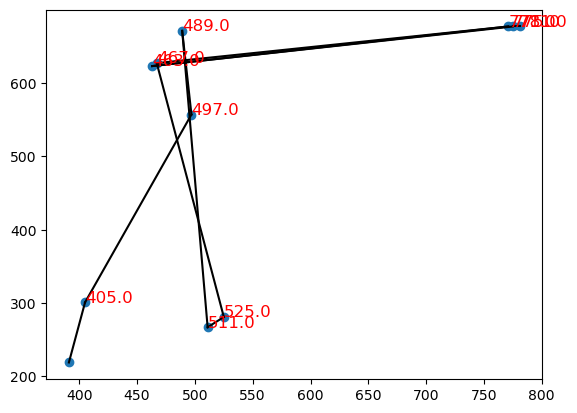

In [156]:

plt.scatter(x, y)

#plot line between consecutive points
for i in range(1, len(x)):
    plt.plot([x[i-1], x[i]], [y[i-1], y[i]], 'k-')
    # for each point add coordinate
    plt.text(x[i], y[i], str(x[i]), color='red', fontsize=12)